![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# *Yahoo Answers Topic Classification*

### Authors: **Tirdod Behbehani, Marvin Ernst, Pol Garcia, Oliver Tausendschön** 

#### Class: **22DM015 Advanced Methods in Natural Language Processing**

##### *Final Assigment*

##### Supervisor: **Arnault Gombert**

**Date: June 15, 2025**


# **Part 4: Model Distillation and Quantization**

In this section, we aim to reduce the computational load of our best-performing model from Part 3. This is essential for efficient deployment in resource-constrained environments.

We want to reduce computational cost, while retaining as much perfromance as possible.

**Importing the relevant libraries:**

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import DistilBertTokenizerFast, DistilBertConfig, DistilBertForSequenceClassification
from transformers import BertModel, BertTokenizer, DistilBertModel, DistilBertTokenizer

from datasets import load_dataset, Dataset
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW

import torch.nn.functional as F

from sklearn.metrics import accuracy_score, precision_score, recall_score

import os
import time
import matplotlib.pyplot as plt

import json
from tqdm import tqdm

from torch.quantization import quantize_dynamic

import copy

from torch.nn.functional import softmax

Set a  seed for reproducibility:

In [4]:
seed = 42
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(seed)

## a. Model Distillation/Quantization 

**Goal**: Convert our large BERT-based model into a smaller and faster model using knowledge distillation and/or quantization techniques.

### **1. Distillation Setup**

We will use the `distilbert-base-uncased` architecture as our student model. The teacher is our fine-tuned BERT model from Part 2, which was our best model.

(For the teacher model we don't explicitly have to align label mapping to integer-based labels since they are already 0–9).

Before we have been using hugging face, however, we encountered issues with it, thus we store the model locally, we will send you the zip file to the pretrained BERT model.

This would be the hugging face option, which we still use for the tokenizer:

In [ ]:
from huggingface_hub import login
# Login to Hugging Face Hub
#login(token=".....")

teacher_ckpt_tokenizer = "tirdodbehbehani/yahoo-bert-32shot_stratified_augm_2"

This is when model is stored locally:

In [6]:
# the path to the pretrained model:
teacher_ckpt = "yahoo_models_best_checkpoints/results_5/checkpoint-2460"
teacher_model = AutoModelForSequenceClassification.from_pretrained(teacher_ckpt)
teacher_tokenizer = AutoTokenizer.from_pretrained(teacher_ckpt_tokenizer)

student_ckpt = "distilbert-base-uncased"
student_model = DistilBertForSequenceClassification.from_pretrained(student_ckpt, num_labels=10)
student_tokenizer = DistilBertTokenizerFast.from_pretrained(student_ckpt)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### **2. Dataset Preparation**

We will use 5% of the dataset for distillation due to computational constraints, since the goal is here to investigate how we can do a best possible distillation, that still gets close in perfromance to the teacher's model (so we are also using the teacher's model that has been trained on 5% of the data). Of course one could also go for 100%, however the learnings would be similar.

First, we load the Yahoo dataset:

In [7]:
df = pd.concat([
    load_dataset("community-datasets/yahoo_answers_topics", split="train").to_pandas(),
    load_dataset("community-datasets/yahoo_answers_topics", split="test").to_pandas()
])

df = df[df["question_content"].str.strip() != ""]
df = df[df["best_answer"].str.strip() != ""]
df = df[["question_content", "topic"]].rename(columns={"topic": "label"})
df["label"] = df["label"].astype(int)

Sample 5%:

(We had tried using a fixed label map consistent with teacher training, but this is redundant, since labels are already 0-9.)

In [8]:
df_sample, _ = train_test_split(df, train_size=0.05, stratify=df["label"], random_state=42)
df_sample = df_sample.reset_index(drop=True)

Convert to Hugging Face Dataset:

In [9]:
dataset = Dataset.from_pandas(df_sample)

We define a function that uses the student tokenizer (i.e., DistilBERT) to tokenize our input texts:

In [10]:
def tokenize_student(example):
    return student_tokenizer(example["question_content"], truncation=True, padding="max_length", max_length=128)

We apply the tokenizer to our full dataset and split it into 80% training and 20% test data (with fixed seed, so everzone can reproduce it). And we format it as PyTorch tensors.

In [11]:
dataset = dataset.map(tokenize_student, batched=True)
dataset = dataset.train_test_split(test_size=0.2, seed=42)
dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/39297 [00:00<?, ? examples/s]

We are creating an **evaluation function** so we can evaluate the models on the flow, on the sane test data:

In [12]:
def evaluate_all_models(models_dir="models", cache_file="model_eval_cache.json", dataset=None, device="cuda"):
    if dataset is None:
        raise ValueError("You must pass a dataset dictionary with a 'test' split.")

    # Load existing results:
    if os.path.exists(cache_file):
        with open(cache_file, "r") as f:
            cache = json.load(f)
    else:
        cache = {}

    test_loader = DataLoader(dataset["test"], batch_size=64)

    results = []

    for model_name in tqdm(sorted(os.listdir(models_dir))):
        model_path = os.path.join(models_dir, model_name)

        if not os.path.isdir(model_path):
            continue

        if model_name in cache:
            cached = cache[model_name]
            print(f"Using cached results for {model_name}")
            print(f"Accuracy: {cached['accuracy']:.4f}")
            print(f"Precision: {cached['precision']:.4f}")
            print(f"Recall: {cached['recall']:.4f}")
            results.append(cached)
            continue

        print(f"\nEvaluating {model_name}")
        model = DistilBertForSequenceClassification.from_pretrained(model_path, local_files_only=True).to(device)
        model.eval()

        all_preds, all_labels = [], []

        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].cpu().numpy()

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, axis=1).cpu().numpy()

                all_preds.extend(preds)
                all_labels.extend(labels)

        acc = accuracy_score(all_labels, all_preds)
        prec = precision_score(all_labels, all_preds, average="macro")
        rec = recall_score(all_labels, all_preds, average="macro")

        print(f"Accuracy:  {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall:    {rec:.4f}")

        result = {
            "version": model_name,
            "accuracy": acc,
            "precision": prec,
            "recall": rec
        }

        # Save to cache and results:
        cache[model_name] = result
        results.append(result)

        # We save after every model:
        with open(cache_file, "w") as f:
            json.dump(cache, f, indent=2)

    return results

### **3. Distillation Training**

We batch the training data into mini-batches of 32 and shuffle them each epoch to reduce overfitting.

We use a simple loss function that encourages the student to match the teacher's predictions, this is AdamW, the standard optimizer (we had also used before).

(Note that runtime we will compare after we have selected the best couple distilled models that have been trained for ,ore than 1 epoch etc., what we are doing right now is first to find good configurations.)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_model.to(device).eval()
student_model.to(device).train()

train_loader = DataLoader(dataset["train"], batch_size=32, shuffle=True)
optimizer = AdamW(student_model.parameters(), lr=5e-5)

This is for the validation (when we do earlzy stopping) to avoid overfitting we can evaluate on the test set (here we use batch size 64):

In [14]:
val_loader = DataLoader(dataset["test"], batch_size=64)

We define a distillation loss that combines **cross-entropy loss** and **Kullback-Leibler divergence**.

The paramters that we define here are:

**temperature**: softens probabilities, making them more informative, we set it at 2, with this we have smoother distributions as we have see in lecture 9 (slide 18). This means we have more randomness in LLMs, here it means that the model is less canfidence in the distillation. So the student model can learn fine grained-relationships between classes.

**alpha**: controls trade-off between matching true labels (CE) and teacher behavior (KL), so how much weight we give to the ground truth vs. the teacher. So with 0.5 we "equally" balance between the true labels and the teacher knowledge (via the KL divergence on the softened logits).

In [15]:
def distillation_loss(student_logits, teacher_logits, true_labels, alpha=0.5, temperature=2.0):
    ce_loss = F.cross_entropy(student_logits, true_labels)
    kl_loss = F.kl_div(
        F.log_softmax(student_logits / temperature, dim=1),
        F.softmax(teacher_logits / temperature, dim=1),
        reduction="batchmean"
    ) * (temperature ** 2)
    return alpha * ce_loss + (1 - alpha) * kl_loss

#### *First Version of the Student Model*

Just with three epochs and temperature = 2.0 and alpha 0.5.

**Training Loop (Distillation):**

We are using real teacher probabilities, not just argmax. With argmax, we would be doing hard predictions like [0,0,1,0,0,1,0,...]. But we are using soft distribution over classes, because they can carry moreinformation as hard labels. Obviouslz, if you consider distributions and when outcomes are Bernoulli, that is the least informative ditribution, you only know for example that class 2 is correct, but zou do not have anz information about the others. If you have soft targets (probability distribution) from the teacher, e.g., [0.01, 0.05, 0.70, 0.23, 0.01, ..., 0.00], then you learn that the teacher is mostly confident in class 2, but also thinks class 3 is plausible (e.g., it relates to computers),and class 1 is mildly relevant (math-related learning). The student now gets more nuanced supervision - not just "what’s correct," but also "how close are other classes?" So what we get is a bigger or richer signal than we would get from the true label alone.

In [22]:
for epoch in range(3):
    total_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        with torch.no_grad():
            teacher_logits = teacher_model(input_ids=input_ids, attention_mask=attention_mask).logits

        student_logits = student_model(input_ids=input_ids, attention_mask=attention_mask).logits
        loss = distillation_loss(student_logits, teacher_logits, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
    print(f"Epoch {epoch + 1}: Loss = {total_loss:.4f}")

Epoch 1: Loss = 1370.8307
Epoch 2: Loss = 1370.8407
Epoch 3: Loss = 1370.6875


This took 14 minutes and 27.1 seconds on a computer with GPU (NVIDIA GeForce RTX 4060 8GB GDDR6.)

We can see that the student model is not really improving much, so it has already learned from both the teacher's predictions and the true labels (so more epochs may not lead to better perfromance).

Save student model (first version):

In [23]:
save_path = "models/student_v1"
student_model.save_pretrained(save_path)
student_tokenizer.save_pretrained(save_path)

('models/student_v1/tokenizer_config.json',
 'models/student_v1/special_tokens_map.json',
 'models/student_v1/vocab.txt',
 'models/student_v1/added_tokens.json',
 'models/student_v1/tokenizer.json')

In [16]:
results = evaluate_all_models(
    models_dir="models",
    cache_file="model_eval_cache.json",
    dataset=dataset,
    device="cuda" if torch.cuda.is_available() else "cpu"
)

100%|██████████| 1/1 [00:00<00:00, 5349.88it/s]

Using cached results for student_v1
Accuracy: 0.8272
Precision: 0.8281
Recall: 0.8238


We can see that the perfromance is already quite good for the first very simple version, still, we want to try to further improve it.

#### *Diverse Versions of the Student Model*

Before we do further exploration of the student with different attention heads or hidden layers, or even longer training, using more epochs, we will first inspect different distillation parameters:

**temperature**: 1.0, 2.0, 5.0

Higher = softer logits = more signal in probabilities.

**alpha**: 0.2, 0.5, 0.8

Give more weight to matching the teacher.

We still include the initial setup, since we now only want to do it with one epoch, just to see which may be better parameters (so it is comparable). We are also using batch size 64 for faster evaluation.

In [17]:
train_loader = DataLoader(dataset["train"], batch_size=64, shuffle=True)

# Parameter grid
alphas = [0.2, 0.5, 0.8]
temperatures = [1.0, 2.0, 5.0]

for alpha in alphas:
    for temperature in temperatures:
        print(f"\nTraining student model with alpha={alpha}, temperature={temperature}")

        # Fresh student model each time
        student_model = DistilBertForSequenceClassification.from_pretrained(
            "distilbert-base-uncased", num_labels=10
        ).to(device)
        optimizer = AdamW(student_model.parameters(), lr=5e-5)
        student_model.train()

        total_loss = 0

        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            with torch.no_grad():
                teacher_logits = teacher_model(input_ids=input_ids, attention_mask=attention_mask).logits

            student_logits = student_model(input_ids=input_ids, attention_mask=attention_mask).logits
            loss = distillation_loss(student_logits, teacher_logits, labels, alpha=alpha, temperature=temperature)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_loss += loss.item()

        print(f"Epoch 1 done for alpha={alpha}, temperature={temperature} | Loss: {total_loss:.4f}")

        # Save model and tokenizer
        save_path = f"models/student_a{alpha}_t{temperature}/"
        os.makedirs(save_path, exist_ok=True)
        student_model.save_pretrained(save_path)
        student_tokenizer.save_pretrained(save_path)


Training student model with alpha=0.2, temperature=1.0


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 done for alpha=0.2, temperature=1.0 | Loss: 417.8267

Training student model with alpha=0.2, temperature=2.0


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 done for alpha=0.2, temperature=2.0 | Loss: 678.6311

Training student model with alpha=0.2, temperature=5.0


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 done for alpha=0.2, temperature=5.0 | Loss: 602.1761

Training student model with alpha=0.5, temperature=1.0


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 done for alpha=0.5, temperature=1.0 | Loss: 487.7130

Training student model with alpha=0.5, temperature=2.0


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 done for alpha=0.5, temperature=2.0 | Loss: 658.4089

Training student model with alpha=0.5, temperature=5.0


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 done for alpha=0.5, temperature=5.0 | Loss: 619.1440

Training student model with alpha=0.8, temperature=1.0


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 done for alpha=0.8, temperature=1.0 | Loss: 556.1922

Training student model with alpha=0.8, temperature=2.0


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 done for alpha=0.8, temperature=2.0 | Loss: 631.4859

Training student model with alpha=0.8, temperature=5.0


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 done for alpha=0.8, temperature=5.0 | Loss: 613.5604


**Evaluate the Performance:**

In [18]:
results = evaluate_all_models(
    models_dir="models",
    cache_file="model_eval_cache.json",
    dataset=dataset,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]


Evaluating student_a0.2_t1.0


 10%|█         | 1/10 [00:14<02:14, 14.99s/it]

Accuracy:  0.6670
Precision: 0.6679
Recall:    0.6626

Evaluating student_a0.2_t2.0


 20%|██        | 2/10 [00:30<02:00, 15.01s/it]

Accuracy:  0.6651
Precision: 0.6663
Recall:    0.6623

Evaluating student_a0.2_t5.0


 30%|███       | 3/10 [00:45<01:45, 15.02s/it]

Accuracy:  0.6665
Precision: 0.6670
Recall:    0.6634

Evaluating student_a0.5_t1.0


 40%|████      | 4/10 [01:00<01:30, 15.03s/it]

Accuracy:  0.6651
Precision: 0.6661
Recall:    0.6614

Evaluating student_a0.5_t2.0


 50%|█████     | 5/10 [01:15<01:15, 15.04s/it]

Accuracy:  0.6599
Precision: 0.6679
Recall:    0.6538

Evaluating student_a0.5_t5.0


 60%|██████    | 6/10 [01:30<01:00, 15.05s/it]

Accuracy:  0.6651
Precision: 0.6724
Recall:    0.6625

Evaluating student_a0.8_t1.0


 70%|███████   | 7/10 [01:45<00:45, 15.05s/it]

Accuracy:  0.6604
Precision: 0.6618
Recall:    0.6582

Evaluating student_a0.8_t2.0


 80%|████████  | 8/10 [02:00<00:30, 15.05s/it]

Accuracy:  0.6581
Precision: 0.6698
Recall:    0.6516

Evaluating student_a0.8_t5.0


100%|██████████| 10/10 [02:15<00:00, 13.54s/it]

Accuracy:  0.6659
Precision: 0.6607
Recall:    0.6637
Using cached results for student_v1
Accuracy: 0.8272
Precision: 0.8281
Recall: 0.8238


From this we can see that the combination of alpha = 0.2 and temperature = 1.0 yielded the best results in terms of overall performance. It achieved the lowest training loss (417.83) and the highest evaluation accuracy (66.70%), along with strong precision and recall values. This means that our student model benefitted most from a stronger emphasis on the teacher's predictions (1 - alpha = 0.8) and sharper (less softened) output distributions from the teacher (temperature = 1.0).

When increasing the temperature to 2.0 or 5.0, we observe higher training loss and slightly lower accuracy across all alpha values. This suggests that over-smoothing the teacher's output distribution (via higher temperatures) made the learning signal less precise, especially for a student trained on only one epoch and a limited dataset.

Similarly, increasing alpha, which shifts the loss more toward the ground truth labels, did not yield better performance. For example, with alpha = 0.8, the models performed consistently worse across all temperatures. This indicates that the teacher’s knowledge was more informative than the sparse ground truth in this few-shot setting, and leveraging that knowledge more (via a lower alpha) was beneficial.

So this tells us that for fast, low-resource distillation, it's best to rely more on the teacher predictions (meaning low alpha), and also to keep the teacher outputs sharp (low temperature), and limit over-smoothing and underfitting by avoiding overly softened distributions or too much reliance on hard labels.

For all future experiments, we therefore fix the distillation parameters to **alpha = 0.2 and temperature = 1.0**.

Note that of course we see that with the smaller batch size we had better perfromance, but now for tuning paprameters, we will stick with 64, and then later reduce it for the model with the best parameters again to 32 and then train it with more epochs.

#### *Different Hidden Layer and Dimension Versions of a Non-Student Model*

Now,  we evaluate variants of the student model without using pretrained weights, since we are deviating from the default DistilBERT architecture (i.e., number of layers and hidden size). These models are initialized from scratch and trained using only the supervision provided by the teacher through distillation.

Full BERT consists of 12 layers, while DistilBERT reduces this to 6 layers. Here, we experiment with 4 layers, to further reduce inference cost, and 8 layers, which increases capacity and may enable the student to better approximate the teacher’s behavior during distillation, despite not starting from pretrained knowledge.


In addition to the number of layers, we vary the hidden dimension, which determines the size of the embeddings and the hidden states within each transformer block. DistilBERT uses a hidden size of 768 by default. We test 768, the standard width, and 384, a smaller variant that significantly reduces the number of parameters and computational cost.

We are also testing for different hidden dimensions. The hidden dimension defines the size of the embeddings and hidden states within each transformer block. DistilBERT uses a hidden size of 768 by default. We test the following two configurations: 768 (standard width), and 384, a smaller variant that significantly reduces the number of parameters and compute.


For each configuration the feedforward (intermediate) dimension is set to four times the hidden size and the number of attention heads is chosen to ensure hidden_size % num_heads = 0.

This setup allows us to explore how well different randomly initialized architectures can learn from a strong teacher via distillation, and how size impacts performance when not relying on pretrained knowledge.

Best parameters from previous distillation sweep:

In [ ]:
alpha = 0.2
temperature = 1.0

Training with this new hidden layer and dimensions configurations:

In [20]:
hidden_layer_options = [4, 6, 8]
hidden_dim_options = [384, 768]

for num_layers in hidden_layer_options:
    for dim in hidden_dim_options:
        print(f"\nTraining student with {num_layers} layers and dim={dim}")

        # Defining the model configuration:
        config = DistilBertConfig(
            num_labels=10,
            n_layers=num_layers,
            dim=dim, # embedding and hidden state size
            hidden_dim=dim * 4,# feedforward size (standard)
            n_heads=dim // 64, # ensure heads divide dim (e.g., 6 for dim=384)
        )
        student_model = DistilBertForSequenceClassification(config).to(device)
        optimizer = AdamW(student_model.parameters(), lr=5e-5)
        student_model.train()

        total_loss = 0

        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            with torch.no_grad():
                teacher_logits = teacher_model(input_ids=input_ids, attention_mask=attention_mask).logits

            student_logits = student_model(input_ids=input_ids, attention_mask=attention_mask).logits
            loss = distillation_loss(student_logits, teacher_logits, labels, alpha=alpha, temperature=temperature)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_loss += loss.item()

        print(f"Epoch 1 complete | Layers: {num_layers}, Dim: {dim} | Loss: {total_loss:.4f}")

        # Save model
        save_path = f"models/student_l{num_layers}_d{dim}_a{alpha}_t{temperature}/"
        os.makedirs(save_path, exist_ok=True)
        student_model.save_pretrained(save_path)
        student_tokenizer.save_pretrained(save_path)


Training student with 4 layers and dim=384
Epoch 1 complete | Layers: 4, Dim: 384 | Loss: 861.1549

Training student with 4 layers and dim=768
Epoch 1 complete | Layers: 4, Dim: 768 | Loss: 781.6780

Training student with 6 layers and dim=384
Epoch 1 complete | Layers: 6, Dim: 384 | Loss: 856.0326

Training student with 6 layers and dim=768
Epoch 1 complete | Layers: 6, Dim: 768 | Loss: 792.1129

Training student with 8 layers and dim=384
Epoch 1 complete | Layers: 8, Dim: 384 | Loss: 846.5542

Training student with 8 layers and dim=768
Epoch 1 complete | Layers: 8, Dim: 768 | Loss: 796.0934


**Evaluate the Performance:**

In [21]:
results = evaluate_all_models(
    models_dir="models",
    cache_file="model_eval_cache.json",
    dataset=dataset,
    device=device
)

  0%|          | 0/16 [00:00<?, ?it/s]

Using cached results for student_a0.2_t1.0
Accuracy: 0.6670
Precision: 0.6679
Recall: 0.6626
Using cached results for student_a0.2_t2.0
Accuracy: 0.6651
Precision: 0.6663
Recall: 0.6623
Using cached results for student_a0.2_t5.0
Accuracy: 0.6665
Precision: 0.6670
Recall: 0.6634
Using cached results for student_a0.5_t1.0
Accuracy: 0.6651
Precision: 0.6661
Recall: 0.6614
Using cached results for student_a0.5_t2.0
Accuracy: 0.6599
Precision: 0.6679
Recall: 0.6538
Using cached results for student_a0.5_t5.0
Accuracy: 0.6651
Precision: 0.6724
Recall: 0.6625
Using cached results for student_a0.8_t1.0
Accuracy: 0.6604
Precision: 0.6618
Recall: 0.6582
Using cached results for student_a0.8_t2.0
Accuracy: 0.6581
Precision: 0.6698
Recall: 0.6516
Using cached results for student_a0.8_t5.0
Accuracy: 0.6659
Precision: 0.6607
Recall: 0.6637

Evaluating student_l4_d384_a0.2_t1.0


 62%|██████▎   | 10/16 [00:03<00:01,  3.27it/s]

Accuracy:  0.4001
Precision: 0.3538
Recall:    0.3860

Evaluating student_l4_d768_a0.2_t1.0


 69%|██████▉   | 11/16 [00:13<00:07,  1.54s/it]

Accuracy:  0.4884
Precision: 0.4933
Recall:    0.4779

Evaluating student_l6_d384_a0.2_t1.0


 75%|███████▌  | 12/16 [00:17<00:07,  1.99s/it]

Accuracy:  0.3715
Precision: 0.3625
Recall:    0.3626

Evaluating student_l6_d768_a0.2_t1.0


 81%|████████▏ | 13/16 [00:32<00:12,  4.33s/it]

Accuracy:  0.4841
Precision: 0.4862
Recall:    0.4766

Evaluating student_l8_d384_a0.2_t1.0


 88%|████████▊ | 14/16 [00:38<00:09,  4.65s/it]

Accuracy:  0.3802
Precision: 0.3601
Recall:    0.3719

Evaluating student_l8_d768_a0.2_t1.0


100%|██████████| 16/16 [00:58<00:00,  3.68s/it]

Accuracy:  0.4630
Precision: 0.5029
Recall:    0.4505
Using cached results for student_v1
Accuracy: 0.8272
Precision: 0.8281
Recall: 0.8238


From these results, we can clearly observe a substantial performance difference between student models initialized with pretrained weights and those trained from scratch.

The first block (students labeled with student_a...) shows results from models that retain the standard DistilBERT architecture (6 layers, 768 hidden dim) and are initialized with pretrained weights. These models reach an accuracy around 66.5%-66.7%, indicating that the knowledge distilled from the teacher is effectively guiding the student. The performance remains quite stable across different values of alpha and temperature, showing robustness of the distillation setup when using a well-initialized student.

In contrast, the second block (students labeled student_l...) shows models with custom architectures (4/6/8 layers, 384/768 hidden size) that were initialized from scratch. These models perform significantly worse, with accuracies ranging from 37% to 49%. Even the largest variant tested (l4_d768 or l6_d768) fails to reach the baseline set by the pretrained student models. The worst performing variants (e.g., l6_d384, l8_d384) show that simply adding layers or reducing hidden size, without the benefit of pretrained weights, leads to unstable and ineffective training under distillation.

This highlights the importance of pretrained initialization, especially when using relatively shallow students. While training from scratch may offer flexibility in architectural choices, it also makes optimization much harder, especially in low-data or one-epoch distillation settings like this.

As we had expected, pretrained student models with default architecture perform significantly better under distillation. The custom student models trained from scratch suffer from poor accuracy and cannot leverage the teacher’s knowledge effectively.

However, if architectural changes are desired (e.g., fewer layers or smaller dimensions), it may be crucial to pretrain these models first (e.g., via masked language modeling) before distillation!

#### *Different Learning Rate Versions of the Student Model*

Next, we investigate how varying the learning rate impacts the performance of the student model. The learning rate controls how much the model updates its weights during training and is often one of the most sensitive hyperparameters in optimization.

Previously, we fixed the learning rate at `5e-5`. While this is commonly used for BERT-like models, smaller student architectures may benefit from **slightly larger** learning rates to compensate for reduced capacity and encourage faster adaptation.

We evaluate the following learning rates:

- **3e-5**: A conservative value often used for full fine-tuning with large models.
- **5e-5**: The baseline used in all previous experiments.
- **1e-4**: A more aggressive value that can help smaller models converge faster, especially during short (1-epoch) training.

Each student model uses the best distillation parameters (`alpha = 0.2`, `temperature = 1.0`) and is trained for one epoch, as before. We fix the architecture using the default number of layers and dimensions so we can use the pretrained weights.

In [23]:
# Learning rates to evaluate
learning_rates = [3e-5, 5e-5, 1e-4]

# Best distillation params
alpha = 0.2
temperature = 1.0

for lr in learning_rates:
    print(f"\nTraining student with lr={lr}")

    # Load pretrained DistilBERT with classification head
    student_model = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased", num_labels=10
    ).to(device)

    optimizer = AdamW(student_model.parameters(), lr=lr)
    student_model.train()

    total_loss = 0

    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        with torch.no_grad():
            teacher_logits = teacher_model(input_ids=input_ids, attention_mask=attention_mask).logits

        student_logits = student_model(input_ids=input_ids, attention_mask=attention_mask).logits
        loss = distillation_loss(student_logits, teacher_logits, labels, alpha=alpha, temperature=temperature)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    print(f"Epoch 1 complete | LR: {lr:.0e} | Loss: {total_loss:.4f}")

    # Save the model
    save_path = f"models/student_pretrained_lr{lr:.0e}_a{alpha}_t{temperature}/"
    os.makedirs(save_path, exist_ok=True)
    student_model.save_pretrained(save_path)
    student_tokenizer.save_pretrained(save_path)


Training student with lr=3e-05


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 complete | LR: 3e-05 | Loss: 432.5083

Training student with lr=5e-05


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 complete | LR: 5e-05 | Loss: 420.8752

Training student with lr=0.0001


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 complete | LR: 1e-04 | Loss: 409.9021


**Evaluate the Performance:**

In [24]:
results = evaluate_all_models(
    models_dir="models",
    cache_file="model_eval_cache.json",
    dataset=dataset,
    device=device
)

  0%|          | 0/19 [00:00<?, ?it/s]

Using cached results for student_a0.2_t1.0
Accuracy: 0.6670
Precision: 0.6679
Recall: 0.6626
Using cached results for student_a0.2_t2.0
Accuracy: 0.6651
Precision: 0.6663
Recall: 0.6623
Using cached results for student_a0.2_t5.0
Accuracy: 0.6665
Precision: 0.6670
Recall: 0.6634
Using cached results for student_a0.5_t1.0
Accuracy: 0.6651
Precision: 0.6661
Recall: 0.6614
Using cached results for student_a0.5_t2.0
Accuracy: 0.6599
Precision: 0.6679
Recall: 0.6538
Using cached results for student_a0.5_t5.0
Accuracy: 0.6651
Precision: 0.6724
Recall: 0.6625
Using cached results for student_a0.8_t1.0
Accuracy: 0.6604
Precision: 0.6618
Recall: 0.6582
Using cached results for student_a0.8_t2.0
Accuracy: 0.6581
Precision: 0.6698
Recall: 0.6516
Using cached results for student_a0.8_t5.0
Accuracy: 0.6659
Precision: 0.6607
Recall: 0.6637
Using cached results for student_l4_d384_a0.2_t1.0
Accuracy: 0.4001
Precision: 0.3538
Recall: 0.3860
Using cached results for student_l4_d768_a0.2_t1.0
Accuracy: 0

 84%|████████▍ | 16/19 [00:15<00:02,  1.06it/s]

Accuracy:  0.6609
Precision: 0.6671
Recall:    0.6575

Evaluating student_pretrained_lr3e-05_a0.2_t1.0


 89%|████████▉ | 17/19 [00:30<00:04,  2.10s/it]

Accuracy:  0.6636
Precision: 0.6643
Recall:    0.6594

Evaluating student_pretrained_lr5e-05_a0.2_t1.0


100%|██████████| 19/19 [00:45<00:00,  2.38s/it]

Accuracy:  0.6588
Precision: 0.6591
Recall:    0.6538
Using cached results for student_v1
Accuracy: 0.8272
Precision: 0.8281
Recall: 0.8238


From this we can see that varying the learning rate has a noticeable effect on both the training loss and the final evaluation metrics, even when using the same pretrained DistilBERT architecture and fixed distillation parameters (alpha = 0.2, temp. = 1.0).

Based on the training loss after one epoch we can see that it steadily decreases as the learning rate increases, this suggests that higher learning rates help the student model converge faster, likely because the pretrained base allows for more aggressive updates without diverging.

The evaluation performance, however, does not strictly follow the same trend. In terms of accuracy, the 3e-5 was the the best performing configuration. 

From this we can conclude that while 1e-4 led to the lowest training loss, it did not generalize as well as the more conservative 3e-5. This confirms that lower learning rates tend to stabilize training and improve generalization, especially when only training for a single epoch. At the same time, the differences are relatively small, and all three configurations outperformed the student models trained from scratch.

#### *Intermediate Layer Distillation Version of the Student Model*

Next, we extend the standard knowledge distillation setup by adding **intermediate layer distillation**, inspired by the TinyBERT framework.

Instead of only matching the teacher and student logits at the output layer, we now also align the **hidden states** from intermediate transformer layers. This approach enables the student to learn internal representations that are more closely aligned with the teacher, potentially improving generalization and convergence.

We use the pretrained `distilbert-base-uncased` student model and freeze the teacher. We extract hidden states from both models and define a **combined distillation loss** that includes:

- **Soft target loss**: KL divergence between teacher and student logits (as before)
- **Intermediate hidden loss**: Mean squared error between selected hidden layers

We know that the student has fewer layers than the teacher (6), and map corresponding layers using a simple linear strategy (student layers match every 2nd layer of the 12-layer BERT teacher).
Again, if we change the number of layers here, we break the mapping that every second layer of the DistilBERT nicely aligns with the teacher (BERT).



We normalize the intermediate loss by the number of matched layers. Doing that ensures that the scale of the intermediate loss stays roughly independent of the number of matched layers, but it also leads to that the contribution of intermediate supervision is consistent and interpretable. Another point why we do it here, which may be most important is that we can re-use the same loss weight across experiments without needing to adjust for each model depth.

The following function *combines soft label distillation with intermediate hidden state loss (somewhat like TinyBERT-style):*

In [25]:
def intermediate_distillation_loss(student_outputs, teacher_outputs, student_logits, teacher_logits, labels, alpha, temperature):
    # Soft target loss (as before)
    soft_loss = F.kl_div(
        F.log_softmax(student_logits / temperature, dim=-1),
        F.softmax(teacher_logits / temperature, dim=-1),
        reduction="batchmean"
    ) * (temperature ** 2)

    # Supervised loss
    hard_loss = F.cross_entropy(student_logits, labels)

    # Intermediate loss between selected hidden states
    student_hidden = student_outputs.hidden_states  # tuple of tensors
    teacher_hidden = teacher_outputs.hidden_states

    # Match layer i of student to layer 2i of teacher
    inter_loss = 0.0
    for i in range(len(student_hidden)):
        inter_loss += F.mse_loss(student_hidden[i], teacher_hidden[2 * i])
    inter_loss /= len(student_hidden)  # normalize

    # Combine all
    return alpha * soft_loss + (1 - alpha) * hard_loss + 0.1 * inter_loss

**Training:**

Since the intermediate distillation version we want to do builds on top of that same loss framework as the DistilBERT, we keep the alpha and temperature fixed, i.e., the best values that we found. 

However, the learning-rates should be re-evaluated since adding intermediate-layer distillation introduces new gradients and loss components (from hidden states) which changes the optimization, so there are more layers that may contribute to the total loss, the scale of the loss may increase and learning dznamics may increase.

Thus, we again evaluate which is the best learning rate from the same set as before.

The teacher stays frozen during training.

In [26]:
# Teacher model outputs hidden states:
teacher_model.config.output_hidden_states = True

# Training params:
learning_rates = [3e-5, 5e-5, 1e-4]
alpha = 0.2
temperature = 1.0

for lr in learning_rates:
    print(f"\nTraining student with lr={lr}")

    # Load pretrained DistilBERT with classification head and hidden states:
    student_model = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased", num_labels=10,
        output_hidden_states=True
    ).to(device)

    optimizer = AdamW(student_model.parameters(), lr=lr)
    student_model.train()
    teacher_model.eval()  # Teacher stays frozen

    total_loss = 0

    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Get teacher outputs with hidden states
        with torch.no_grad():
            teacher_outputs = teacher_model(input_ids=input_ids, attention_mask=attention_mask)
            teacher_logits = teacher_outputs.logits

        # Get student outputs with hidden states:
        student_outputs = student_model(input_ids=input_ids, attention_mask=attention_mask)
        student_logits = student_outputs.logits

        # Our combined loss:
        loss = intermediate_distillation_loss(
            student_outputs, teacher_outputs,
            student_logits, teacher_logits,
            labels, alpha, temperature
        )

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    print(f"Epoch 1 complete | LR: {lr:.0e} | Loss: {total_loss:.4f}")

    # Save the model:
    save_path = f"models/student_intermediate_lr{lr:.0e}_a{alpha}_t{temperature}/"
    os.makedirs(save_path, exist_ok=True)
    student_model.save_pretrained(save_path)
    student_tokenizer.save_pretrained(save_path)


Training student with lr=3e-05


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 complete | LR: 3e-05 | Loss: 586.3482

Training student with lr=5e-05


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 complete | LR: 5e-05 | Loss: 569.2524

Training student with lr=0.0001


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 complete | LR: 1e-04 | Loss: 560.4650


**Evaluate the Performance:**

In [27]:
results = evaluate_all_models(
    models_dir="models",
    cache_file="model_eval_cache.json",
    dataset=dataset,
    device=device
)

  0%|          | 0/22 [00:00<?, ?it/s]

Using cached results for student_a0.2_t1.0
Accuracy: 0.6670
Precision: 0.6679
Recall: 0.6626
Using cached results for student_a0.2_t2.0
Accuracy: 0.6651
Precision: 0.6663
Recall: 0.6623
Using cached results for student_a0.2_t5.0
Accuracy: 0.6665
Precision: 0.6670
Recall: 0.6634
Using cached results for student_a0.5_t1.0
Accuracy: 0.6651
Precision: 0.6661
Recall: 0.6614
Using cached results for student_a0.5_t2.0
Accuracy: 0.6599
Precision: 0.6679
Recall: 0.6538
Using cached results for student_a0.5_t5.0
Accuracy: 0.6651
Precision: 0.6724
Recall: 0.6625
Using cached results for student_a0.8_t1.0
Accuracy: 0.6604
Precision: 0.6618
Recall: 0.6582
Using cached results for student_a0.8_t2.0
Accuracy: 0.6581
Precision: 0.6698
Recall: 0.6516
Using cached results for student_a0.8_t5.0
Accuracy: 0.6659
Precision: 0.6607
Recall: 0.6637

Evaluating student_intermediate_lr1e-04_a0.2_t1.0


 45%|████▌     | 10/22 [00:15<00:18,  1.51s/it]

Accuracy:  0.6515
Precision: 0.6511
Recall:    0.6516

Evaluating student_intermediate_lr3e-05_a0.2_t1.0


 50%|█████     | 11/22 [00:30<00:35,  3.21s/it]

Accuracy:  0.6623
Precision: 0.6627
Recall:    0.6590

Evaluating student_intermediate_lr5e-05_a0.2_t1.0


100%|██████████| 22/22 [00:45<00:00,  2.06s/it]

Accuracy:  0.6517
Precision: 0.6539
Recall:    0.6489
Using cached results for student_l4_d384_a0.2_t1.0
Accuracy: 0.4001
Precision: 0.3538
Recall: 0.3860
Using cached results for student_l4_d768_a0.2_t1.0
Accuracy: 0.4884
Precision: 0.4933
Recall: 0.4779
Using cached results for student_l6_d384_a0.2_t1.0
Accuracy: 0.3715
Precision: 0.3625
Recall: 0.3626
Using cached results for student_l6_d768_a0.2_t1.0
Accuracy: 0.4841
Precision: 0.4862
Recall: 0.4766
Using cached results for student_l8_d384_a0.2_t1.0
Accuracy: 0.3802
Precision: 0.3601
Recall: 0.3719
Using cached results for student_l8_d768_a0.2_t1.0
Accuracy: 0.4630
Precision: 0.5029
Recall: 0.4505
Using cached results for student_pretrained_lr1e-04_a0.2_t1.0
Accuracy: 0.6609
Precision: 0.6671
Recall: 0.6575
Using cached results for student_pretrained_lr3e-05_a0.2_t1.0
Accuracy: 0.6636
Precision: 0.6643
Recall: 0.6594
Using cached results for student_pretrained_lr5e-05_a0.2_t1.0
Accuracy: 0.6588
Precision: 0.6591
Recall: 0.6538
Usin

From this we can see that training smaller student architectures from scratch, even when incorporating intermediate layer supervision, leads to lower performance compared to models that utilize pretrained weights. All models were initialized from the base pretrained checkpoint, with classification layers newly initialized.

During training, the total loss decreased as the learning rate increased. At a learning rate of 3e-5, the model reached a loss of approximately 586.35. With 5e-5, the loss dropped to 569.25, and with 1e-4 it decreased further to 560.47. This pattern indicates that larger learning rates help the student model adapt more quickly, especially when layers such as the classification head are randomly initialized and only limited training is performed.

However, when evaluating performance on the validation set, the relationship between learning rate and generalization was less straightforward. The model trained with the lowest learning rate, 3e-5, achieved the highest accuracy at 66.23%. The models trained with 5e-5 and 1e-4 achieved slightly lower accuracies of 65.17% and 65.15%, respectively. From this we can see that although larger learning rates reduce training loss, they do not necessarily improve validation accuracy, so the more conservative learning rate of 3e-5 appears to offer the best balance between learning and generalization in this setup.

Compared to the TinyBERT-style scratch-trained models (from earlier) with reduced hidden size and fewer layers (for example 4 layers with 384 hidden dimensions), which struggled to exceed 49% accuracy, the intermediate distillation models, which preserve the full DistilBERT architecture and leverage both soft targets and hidden state alignment, achieved significantly better results, reaching over 66% accuracy. This demonstrates the strong benefit of combining pretrained knowledge with intermediate supervision, even when the training data and number of epochs are limited.

Nevertheless, these models still slightly underperform relative to the best student models trained with standard distillation and fully pretrained weights. For instance, the best standard distillation model with a learning rate of 3e-5 reached 66.36% accuracy, outperforming all intermediate distillation variants by a small but consistent margin.

#### *Best Version of the Student Model*

Now, we run our best models with maximum 20 epochs and early stopping, where we stop the training if it does not improve after 3 epochs. We also use a batch size of 32 now (and not 64). The models we include are:

One version of the standard distillation (pretrained encoder), the *student_pretrained_lr3e-05_a0.2_t1.0*, since it has the best current performance, fewer moving parts, so we can see how much performance can improve over more epochs.

And one version of the intermediate distillation (TinyBERT-style, pretrained encoder), the *student_intermediate_lr3e-05_a0.2_t1.0*, since it benefits from both soft targets and internal representation alignment, so we can test if its advantage increases over time and training steps.

We first set the batch size to 32:

In [28]:
train_loader = DataLoader(dataset["train"], batch_size=32, shuffle=True)

**Training loop:**

In [ ]:
def train_student_model(
    student_model, 
    student_tokenizer,
    train_loader,
    val_loader,
    teacher_model,
    optimizer,
    loss_fn,  
    model_name,  
    alpha=0.2,
    temperature=1.0,
    patience=3,
    max_epochs=20
):
    best_val_acc = 0
    counter = 0
    train_losses = []
    val_accuracies = []

    for epoch in range(max_epochs):
        student_model.train()
        total_loss = 0

        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            with torch.no_grad():
                teacher_outputs = teacher_model(input_ids=input_ids, attention_mask=attention_mask)
                teacher_logits = teacher_outputs.logits

            student_outputs = student_model(input_ids=input_ids, attention_mask=attention_mask)
            student_logits = student_outputs.logits

            # Handle standard vs. intermediate distillation loss:
            if loss_fn.__name__ == "distillation_loss":
                loss = loss_fn(student_logits, teacher_logits, labels, alpha, temperature)
            else:
                loss = loss_fn(
                    student_outputs,
                    teacher_outputs,
                    student_logits,
                    teacher_logits,
                    labels,
                    alpha,
                    temperature
                )

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch + 1}: Train Loss = {avg_train_loss:.4f}")

        # Validation
        student_model.eval()
        all_preds, all_labels = [], []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].to("cpu").numpy()

                outputs = student_model(input_ids=input_ids, attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()

                all_preds.extend(preds)
                all_labels.extend(labels)

        val_acc = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_acc)
        print(f"Validation Accuracy: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0
            print("New best model found. Saving...")
            save_path = f"models/{model_name}"
            os.makedirs(save_path, exist_ok=True)
            student_model.save_pretrained(save_path)
            student_tokenizer.save_pretrained(save_path)
        else:
            counter += 1
            print(f"No improvement. Early stopping counter: {counter}/{patience}")
            if counter >= patience:
                print("Early stopping triggered.")
                break

    # Loss curve
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, marker='o')
    plt.yscale("log")
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss (log scale)")
    plt.title(f"Loss Curve: {model_name}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

**Load student models:**

In [ ]:
# Standard distillation student (pretrained encoder)
student_pretrained = DistilBertForSequenceClassification.from_pretrained(
    "models/student_pretrained_lr3e-05_a0.2_t1.0"
).to(device)

# Intermediate distillation student (TinyBERT-style)
student_intermediate = DistilBertForSequenceClassification.from_pretrained(
    "models/student_intermediate_lr3e-05_a0.2_t1.0"
).to(device)

# Tokenizer (same for both)
student_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

**Define optimizers:**

In [ ]:
optimizer_pretrained = AdamW(student_pretrained.parameters(), lr=3e-5)
optimizer_intermediate = AdamW(student_intermediate.parameters(), lr=3e-5)

The loss functions are already defined, now we can **start the training:**

Epoch 1: Train Loss = 0.5730
Validation Accuracy: 0.6621
New best model found. Saving...
Epoch 2: Train Loss = 0.3898
Validation Accuracy: 0.6550
No improvement. Early stopping counter: 1/3
Epoch 3: Train Loss = 0.2710
Validation Accuracy: 0.6566
No improvement. Early stopping counter: 2/3
Epoch 4: Train Loss = 0.2049
Validation Accuracy: 0.6654
New best model found. Saving...
Epoch 5: Train Loss = 0.1739
Validation Accuracy: 0.6618
No improvement. Early stopping counter: 1/3
Epoch 6: Train Loss = 0.1574
Validation Accuracy: 0.6637
No improvement. Early stopping counter: 2/3
Epoch 7: Train Loss = 0.1474
Validation Accuracy: 0.6613
No improvement. Early stopping counter: 3/3
Early stopping triggered.


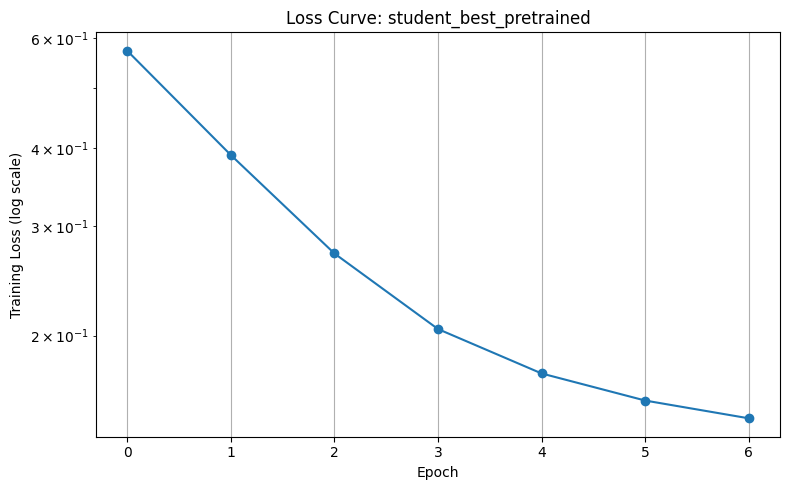

Epoch 1: Train Loss = 0.8747
Validation Accuracy: 0.6686
New best model found. Saving...
Epoch 2: Train Loss = 0.6649
Validation Accuracy: 0.6545
No improvement. Early stopping counter: 1/3
Epoch 3: Train Loss = 0.4914
Validation Accuracy: 0.6508
No improvement. Early stopping counter: 2/3
Epoch 4: Train Loss = 0.3655
Validation Accuracy: 0.6380
No improvement. Early stopping counter: 3/3
Early stopping triggered.


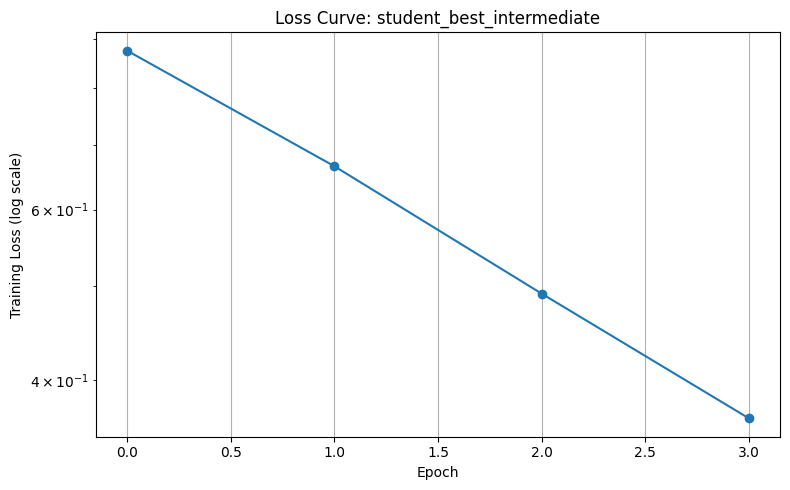

In [ ]:
# Standard distillation
train_student_model(
    student_model=student_pretrained,
    student_tokenizer=student_tokenizer,
    train_loader=train_loader,
    val_loader=val_loader,
    teacher_model=teacher_model,
    optimizer=optimizer_pretrained,
    loss_fn=distillation_loss,
    model_name="student_best_pretrained",
    alpha=0.2,
    temperature=1.0,
)

# Intermediate distillation
train_student_model(
    student_model=student_intermediate,
    student_tokenizer=student_tokenizer,
    train_loader=train_loader,
    val_loader=val_loader,
    teacher_model=teacher_model,
    optimizer=optimizer_intermediate,
    loss_fn=intermediate_distillation_loss,
    model_name="student_best_intermediate",
    alpha=0.2,
    temperature=1.0,
)

**student_best_pretrained**

The standard distilled student model, using a pretrained encoder and trained with soft targets only, shows a clear and steady decrease in training loss over 7 epochs. The log-scaled curve highlights that learning was stable, with diminishing returns over time.

In Epoch 1, the model achieved a training loss of 0.5730 and a validation accuracy of 66.21%, setting the initial performance benchmark.

While the training loss improved substantially in the next two epochs (0.3898 and 0.2710), validation accuracy slightly dropped to 65.50% and 65.66%, triggering early stopping counters.

In Epoch 4, the model reached a new best validation accuracy of 66.54% as training loss further decreased to 0.2049.

The following epochs continued to improve the training loss (down to 0.1474 in Epoch 7), but validation accuracy fluctuated slightly below the peak (66.18%, 66.37%, 66.13%).

Since no further improvement occurred for three consecutive epochs, early stopping was triggered after Epoch 7.

Overall, this model showed solid convergence, and the loss curve suggests that the model was still learning, albeit with reduced gains. The final training loss was low, and validation performance was competitive.

**student_best_intermediate**

This intermediate-distilled model (TinyBERT-style, pretrained encoder, with hidden-state matching) showed faster convergence in terms of loss reduction, but generalization performance did not follow the same trend.

In Epoch 1, the training loss was higher at 0.8747, but the model surprisingly reached the highest validation accuracy of 66.86% right away.

Subsequent epochs saw consistent reductions in training loss (0.6649, 0.4914, and 0.3655), but validation accuracy declined to 65.45%, 65.08%, and 63.80%.

This drop in validation accuracy, despite better training loss, suggests the model may have overfit quickly or learned superficial patterns in early epochs.

After no improvement for three epochs, early stopping was triggered at Epoch 4.

The corresponding loss curve confirms the rapid drop in training loss, but the decoupling from validation performance highlights a generalization issue. The model's strong initial result might reflect a lucky initialization or effective transfer from the internal alignment objective, but it was not sustained.

**Evaluation:**

First we load both saved models:

In [38]:
model_pretrained = DistilBertForSequenceClassification.from_pretrained("models/student_best_pretrained").to(device)
model_intermediate = DistilBertForSequenceClassification.from_pretrained("models/student_best_intermediate").to(device)
tokenizer = DistilBertTokenizer.from_pretrained("models/student_best_pretrained")

Shorter evaluation function, that only shows us the perfromance of those two:

In [53]:
def evaluate(model, dataset, device):
    model.eval()
    model.to(device)
    all_preds, all_labels = [], []

    val_loader = DataLoader(dataset["test"], batch_size=64)

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device) if device != "cpu" else batch["input_ids"]
            attention_mask = batch["attention_mask"].to(device) if device != "cpu" else batch["attention_mask"]
            labels = batch["label"].to("cpu").numpy()  # Always move labels to CPU before .numpy()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="macro")
    recall = recall_score(all_labels, all_preds, average="macro")

    return acc, precision, recall

Final scores:

In [42]:
acc, prec, rec = evaluate(model_pretrained, dataset, device)
print(f"[Standard] Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")

acc, prec, rec = evaluate(model_intermediate, dataset, device)
print(f"[Intermediate] Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")

[Standard] Accuracy: 0.6654, Precision: 0.6634, Recall: 0.6633
[Intermediate] Accuracy: 0.6686, Precision: 0.6671, Recall: 0.6646


The saved student_v1 model:

In [54]:
# Load the saved student_v1 model
model_path = "models/student_v1"
student_v1 = DistilBertForSequenceClassification.from_pretrained(model_path).to(device)

# Evaluate using your new function
acc, prec, rec = evaluate(student_v1, dataset, device)
print(f"[V1 Model] Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")

[V1 Model] Accuracy: 0.8272, Precision: 0.8281, Recall: 0.8238


All results:

In [43]:
results = evaluate_all_models(
    models_dir="models",
    cache_file="model_eval_cache.json",
    dataset=dataset,
    device=device
)

  0%|          | 0/25 [00:00<?, ?it/s]

Using cached results for student_a0.2_t1.0
Accuracy: 0.6670
Precision: 0.6679
Recall: 0.6626
Using cached results for student_a0.2_t2.0
Accuracy: 0.6651
Precision: 0.6663
Recall: 0.6623
Using cached results for student_a0.2_t5.0
Accuracy: 0.6665
Precision: 0.6670
Recall: 0.6634
Using cached results for student_a0.5_t1.0
Accuracy: 0.6651
Precision: 0.6661
Recall: 0.6614
Using cached results for student_a0.5_t2.0
Accuracy: 0.6599
Precision: 0.6679
Recall: 0.6538
Using cached results for student_a0.5_t5.0
Accuracy: 0.6651
Precision: 0.6724
Recall: 0.6625
Using cached results for student_a0.8_t1.0
Accuracy: 0.6604
Precision: 0.6618
Recall: 0.6582
Using cached results for student_a0.8_t2.0
Accuracy: 0.6581
Precision: 0.6698
Recall: 0.6516
Using cached results for student_a0.8_t5.0
Accuracy: 0.6659
Precision: 0.6607
Recall: 0.6637

Evaluating student_best_intermediate


 40%|████      | 10/25 [00:14<00:22,  1.47s/it]

Accuracy:  0.6686
Precision: 0.6671
Recall:    0.6646

Evaluating student_best_pretrained


 44%|████▍     | 11/25 [00:29<00:43,  3.14s/it]

Accuracy:  0.6654
Precision: 0.6634
Recall:    0.6633
Using cached results for student_intermediate_lr1e-04_a0.2_t1.0
Accuracy: 0.6515
Precision: 0.6511
Recall: 0.6516
Using cached results for student_intermediate_lr3e-05_a0.2_t1.0
Accuracy: 0.6623
Precision: 0.6627
Recall: 0.6590
Using cached results for student_intermediate_lr5e-05_a0.2_t1.0
Accuracy: 0.6517
Precision: 0.6539
Recall: 0.6489
Using cached results for student_l4_d384_a0.2_t1.0
Accuracy: 0.4001
Precision: 0.3538
Recall: 0.3860
Using cached results for student_l4_d768_a0.2_t1.0
Accuracy: 0.4884
Precision: 0.4933
Recall: 0.4779
Using cached results for student_l6_d384_a0.2_t1.0
Accuracy: 0.3715
Precision: 0.3625
Recall: 0.3626
Using cached results for student_l6_d768_a0.2_t1.0
Accuracy: 0.4841
Precision: 0.4862
Recall: 0.4766
Using cached results for student_l8_d384_a0.2_t1.0
Accuracy: 0.3802
Precision: 0.3601
Recall: 0.3719
Using cached results for student_l8_d768_a0.2_t1.0
Accuracy: 0.4630
Precision: 0.5029
Recall: 0.450

100%|██████████| 25/25 [00:44<00:00,  1.78s/it]

Accuracy:  0.6546
Precision: 0.6586
Recall:    0.6517


Interpretation will be in part b, since there we will compare them to the teacher directly.

### **4. Dynamic Quantization**

Quantization is a technique used in model compression that reduces the precision of the numbers used to represent model parameters (e.g., weights) and sometimes activations.

Deep learning models typically use 32-bit floating point (FP32) numbers. Quantization reduces this to 8-bit integers (INT8) or 16-bit floats, depending on the method (we use 8).

Dynamic quantization specifically only affects the weights of linear layers and does not require calibration data or retraining, we can do this directly in PyTorch.

We use the v1 student model, which was the best standard distillation student. We only quantize linear layers, because these nn.Linear layers account for most of the FLOPs and memory usage in inference, so quantizing them gives the biggest speed and size gains. Weights are static (don’t change at inference). As said, we use 8-bit integers, this should significantly increase speed.

Since student_v1 is already trained and saved, we uantize only the classifier with PyTorch.

In [ ]:
student_v1_quant = copy.deepcopy(student_v1)

quantized_classifier = torch.quantization.quantize_dynamic(
    student_v1_quant.classifier,
    {torch.nn.Linear},
    dtype=torch.qint8,
)

student_v1_quant.classifier = quantized_classifier

**Evaluate:**

In [61]:
acc, prec, rec = evaluate(student_v1_quant, dataset, device="cpu")
print(f"[Quantized Classifier] Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")

[Quantized Classifier] Accuracy: 0.8272, Precision: 0.8281, Recall: 0.8238


Interpretation, see below.

## b. Performance and Speed Comparison

We first evaluate the stuntent's models and then the teacher model. We evaluate their performance on exactly the same data.

However, we need tot create a separate test dataset for the teacher that uses the teacher tokenizer.

In [62]:
def tokenize_teacher(example):
    return teacher_tokenizer(example["question_content"], truncation=True, padding="max_length", max_length=128)

Apply it to a fresh copy of the dataset:

In [63]:
raw_dataset = Dataset.from_pandas(df_sample.copy())
teacher_dataset = raw_dataset.map(tokenize_teacher, batched=True)
teacher_dataset = teacher_dataset.train_test_split(test_size=0.2, seed=42)
teacher_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/39297 [00:00<?, ? examples/s]

New dataloader:

In [64]:
teacher_test_loader = DataLoader(teacher_dataset["test"], batch_size=64)

**Teacher vs best Models:**

In [65]:
results = []

print("\nEvaluating teacher model")

teacher_model.to(device)
teacher_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in teacher_test_loader:
        # Move all batch items to the same device
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = teacher_model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["label"].cpu().numpy())

# Compute and print metrics
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average="macro", zero_division=0)
rec = recall_score(all_labels, all_preds, average="macro", zero_division=0)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")

# Log results
results.append({
    "version": "teacher",
    "accuracy": acc,
    "precision": prec,
    "recall": rec
})

# Students:
print("\nEvaluating the best student models")

acc, prec, rec = evaluate(model_pretrained, dataset, device)
print(f"[Standard] Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")

acc, prec, rec = evaluate(model_intermediate, dataset, device)
print(f"[Intermediate] Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")

acc, prec, rec = evaluate(student_v1, dataset, device)
print(f"[V1 Model] Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")

acc, prec, rec = evaluate(student_v1_quant, dataset, device="cpu")
print(f"[Quantized Classifier] Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")


Evaluating teacher model
Accuracy:  0.8744
Precision: 0.8730
Recall:    0.8720

Evaluating the best student models
[Standard] Accuracy: 0.6654, Precision: 0.6634, Recall: 0.6633
[Intermediate] Accuracy: 0.6686, Precision: 0.6671, Recall: 0.6646
[V1 Model] Accuracy: 0.8272, Precision: 0.8281, Recall: 0.8238
[Quantized Classifier] Accuracy: 0.8272, Precision: 0.8281, Recall: 0.8238


The V1 model, trained for just 3 epochs with temperature scaling (temp.=2.0) and an equal balance between hard labels and soft teacher targets (alpha=0.5), achieves a validation accuracy of 82.72%, far surpassing both the best standard and intermediate student models.

This is liely due to the fact that V1 was trained with soft targets from a high-performing BERT teacher (accuracy 87%), which provides nuanced information about class probabilities beyond the hard labels. This helped the student learn more than just the "correct" answer. Giving equal importance to the teacher’s logits and the ground truth labels allowed the student to learn both general patterns and dataset-specific decision boundaries. Softened logits exposed inter-class relationships. This richer signal likely improved generalization and robustness. V1 used a clean and focused setup without additional complexity (e.g., no intermediate layer matching), allowing the optimization to proceed without unnecessary distractions or noise in the objective. Even with only 5% of the full dataset, the training was effectively regularized by the teacher’s outputs. The limited data combined with soft labels reduced overfitting and allowed for meaningful generalization.

For the Standard Distilled Student we had longer training, but worse performance, even after early stopping at epoch 7, this model achieved 16 percentage points lower accuracy than V1. It only relied on soft logits resulting in sharper distributions and weaker signals for secondary classes. The extended training didn't help much because the model lacked access to internal teacher knowledge and used low alpha, thereby underutilizing ground truth.

The additional complexity only improved compared to the standard distilled student. This may have hurt generalization and we had rapid overfitting. This shows that more sophisticated objectives can be counterproductive without careful tuning or larger datasets.

The quantified version achieves the same perfromance as the V1.

### Inference Speed Comparison

We do a warm-up for stability.

Sample 100 texts, we do this for all the best models:

In [ ]:
texts = df_sample["question_content"].tolist()[:100]
batch_size = 16  # Reduce if still getting OOM

# model paths
model_variants = {
    "teacher": {
        "model": teacher_model,
        "tokenizer": teacher_tokenizer
    },
    "student_best_pretrained": {
        "model_path": "models/student_best_pretrained"
    },
    "student_best_intermediate": {
        "model_path": "models/student_best_intermediate"
    },
    "student_v1": {
        "model": student_v1,
        "tokenizer": student_tokenizer
    },
    "student_v1_quantized": {
        "model": student_v1_quant,
        "tokenizer": student_tokenizer
    }
}

# Loop through each model version:
for name, info in model_variants.items():
    print(f"\nEvaluating {name}...")

    # Load model/tokenizer
    if "model" in info and "tokenizer" in info:
        model = info["model"].to(device)
        tokenizer = info["tokenizer"]
    else:
        model = DistilBertForSequenceClassification.from_pretrained(info["model_path"]).to(device)
        tokenizer = DistilBertTokenizerFast.from_pretrained(info["model_path"])

    model.eval()

    # Tokenize all texts in advance (on CPU)
    encoded = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    
    # Move tensors to device in batches
    start_time = time.time()
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = {k: v[i:i+batch_size].to(device) for k, v in encoded.items()}
            _ = model(**batch)
    end_time = time.time()

    print(f"Inference time on 100 samples ({name}): {end_time - start_time:.4f} seconds")

    # Optional: clear memory between models
    del model
    torch.cuda.empty_cache()


Evaluating teacher...
Inference time on 100 samples (teacher): 0.7009 seconds

Evaluating student_best_pretrained...
Inference time on 100 samples (student_best_pretrained): 0.3438 seconds

Evaluating student_best_intermediate...
Inference time on 100 samples (student_best_intermediate): 0.3357 seconds

Evaluating student_v1...
Inference time on 100 samples (student_v1): 0.3371 seconds

Evaluating student_v1_quantized...
Inference time on 100 samples (student_v1_quantized): 0.3482 seconds


We observe that the teacher model takes the longest to process 100 samples, with an inference time of approximately 0.70 seconds, reflecting its larger size and complexity. In contrast, all student variants, including the pretrained, intermediate, v1, and quantized versions, achieve significantly faster inference times around 0.33 to 0.35 seconds, demonstrating the efficiency gains achieved through distillation and model compression.

## c. Analysis and Improvements

Last, we are supposed to analyze deficiencies in the student model's learning. Suggest potential improvements or further research directions.

The student models that we chose were limited to the DistilBERT base architecture for the case when we do not want to retrain and use the weights. We saw that already a very simple approach can give very good performance, while benefitting from reduced computaional inference time. 

Even though the models benefit from faster inference and are much faster to be trained one has to consider that the training still takes a signifcant amount of time which leads to the fact that one can even with those models only do some limited parameter tuning.

The most obvious deficiency of the student model's learning is the limited model capacity. Fewer parameters (fewer layers, smaller hidden size, fewer attention heads) mean that it cannot represent complex functions learned by the teacher. Thus, the student may underfit especially on nuanced or ambiguous samples.

While the student may generalize quite good, the student misses depth which makes it worse at modeling complex syntax or abstract semantics.

There could be models that have different number of layers that do not require retraining everything from scratch.

We also suggest experimenting with more advanced quantization techniques, such as post-training quantization with ONNX Runtime or quantization-aware training, which may further reduce memory and inference costs with minimal accuracy degradation. Finally, better distillation objectives that combine soft targets with intermediate layer alignment or contrastive learning may allow student models to capture richer representations without increasing model size.

In [ ]:
def predict(model, tokenizer, texts, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for text in texts:
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
            outputs = model(**inputs)
            probs = softmax(outputs.logits, dim=1)
            pred = torch.argmax(probs, dim=1).item()
            preds.append(pred)
    return preds

# Predict using teacher and student_v1
teacher_preds = predict(teacher_model, teacher_tokenizer, texts, device)
student_preds = predict(student_v1, student_tokenizer, texts, device)

# Compare and print misclassified examples
for i, (true, t_pred, s_pred) in enumerate(zip(labels, teacher_preds, student_preds)):
    if t_pred == true and s_pred != true:
        print(f"\nExample {i}:")
        print(f"Text: {texts[i]}")
        print(f"True Label:     {true}")
        print(f"Teacher Pred:   {t_pred} ")
        print(f"Student V1 Pred:{s_pred} ")


Example 10:
Text: can anyone tell me the medical condition that was on Melbournes all saints on the tuesday the 23td of may thanks
True Label:     3
Teacher Pred:   3 
Student V1 Pred:0 


In this example, the teacher model correctly identifies the topic as class 3, likely a medical or health-related category, while the student V1 model misclassifies it as class 0. The text refers to a medical condition on a TV show, which may require more nuanced understanding of context and domain-specific terms. This suggests that the student model, due to its reduced capacity, struggles to capture such specific references and semantic cues, leading to errors in more specialized or context-dependent queries.